In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
from PIL import Image as pil_image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
import cv2
from cv2 import imread, resize

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing data
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:13<00:00, 77.5MB/s]
100% 5.20G/5.20G [01:14<00:00, 75.4MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
df_skin = pd.read_csv('HAM10000_metadata.csv')
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# lesion names are given in the description of the challenge
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

print('Total number of images',len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

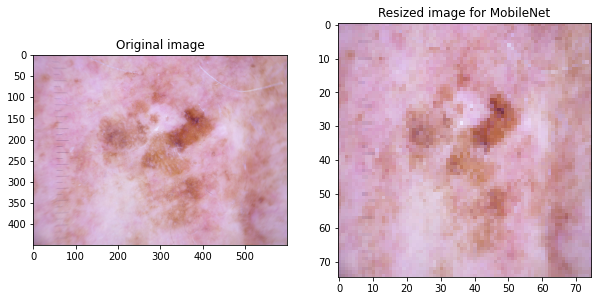

In [ ]:
# read the first image
fname_images = np.array(df_skin['image_id'])
file_to_read ='HAM10000_images_part_1/'+str(fname_images[0])+'.jpg'

import cv2
from cv2 import imread, resize

img = cv2.imread(file_to_read)
img2 = cv2.resize(img,(75,75))

# show one exampe image

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Resized image for MobileNet')
plt.show()

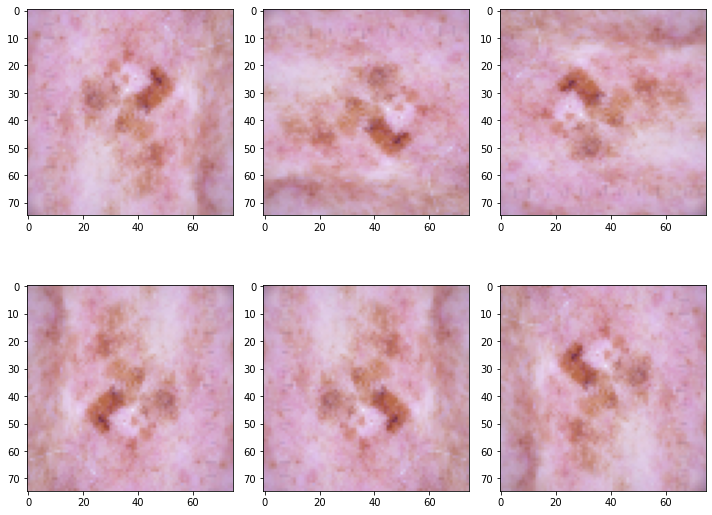

In [ ]:
def produce_new_img(img2):
    # produce new images by rotating of flipping the original one
    # this helps to increase the dimension of the dataset, avoiding overfitting of a single class
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

new_img = produce_new_img(img2)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(img2[:,:,::-1])
for i in range(5):
    plt.subplot(2,3,2+i)
    plt.imshow(new_img[i][:,:,::-1])
plt.tight_layout()
plt.show()

In [ ]:
# import images from 2 different folders

X = []
y = []

lista1 = os.listdir('HAM10000_images_part_1/')
lista2 = os.listdir('HAM10000_images_part_2/')


#import images from folder 1
for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features 
    file_to_read ='HAM10000_images_part_1/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(75,75))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
       
    if i % int(100) == 0:
        print(i,'images loaded')

# import images from folder 2
for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features
    file_to_read ='HAM10000_images_part_2/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(75,75))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
    
    if i % int(100) == 0:

        print(len(lista1)+i,'images loaded')

0 images loaded
200 images loaded
400 images loaded
600 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1400 images loaded
1500 images loaded
1700 images loaded
1800 images loaded
1900 images loaded
2000 images loaded
2200 images loaded
2300 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3000 images loaded
3100 images loaded
3300 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
4000 images loaded
4100 images loaded
4300 images loaded
4400 images loaded
4900 images loaded
5000 images loaded
5200 images loaded
5300 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5800 images loaded
6100 images loaded
6400 images loaded
6900 images loaded
7000 images loaded
7100 images loaded
7200 images loaded
7300 images loaded
7400 images loaded
7500 images loaded
7600 images loaded
7700 images loaded
8100 images loaded
8200 images loaded
8

In [ ]:
from keras.utils.np_utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

# #convert targets in dummy variables, as required by softmax activation function
# y_dumm = np.array(pd.get_dummies(y))

In [ ]:
from sklearn.model_selection import train_test_split

# split in 90% training and 10% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.1, random_state=50,stratify=y)


print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (23908, 75, 75, 3)
Test dataset shape (2657, 75, 75, 3)


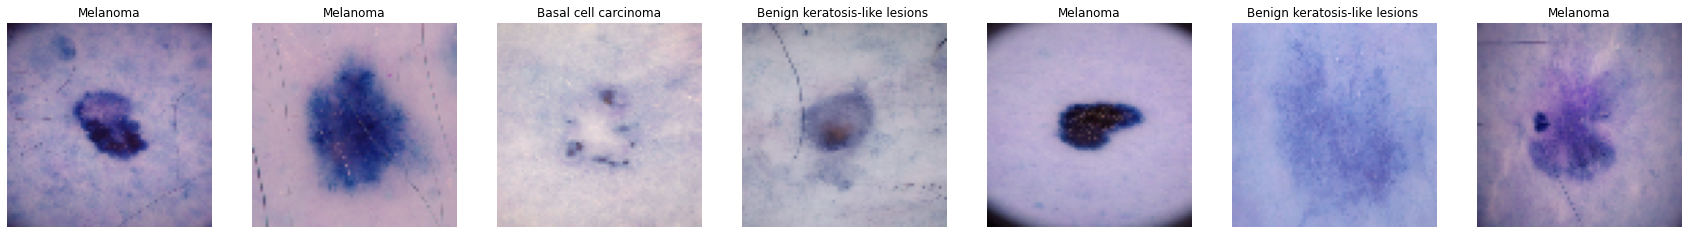

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(30, 30))
for i in range(7):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(lesion_names[np.argmax(y_train[i])])

In [ ]:
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df_skin['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
import tensorflow as tf
tf.keras.applications.mobilenet_v2.preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2

input_shape = (75, 75, 3)
num_classes = 7
from keras.models import Sequential , Model
from keras.layers import Dropout , GlobalAveragePooling2D
model = InceptionResNetV2(weights="imagenet",
include_top=False , input_shape=(75, 75, 3))
x = model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=model.input, outputs=predictions)
model.summary()

219062272/219055592 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
___________________________

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(X_train)
# Fits-the-model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0] //64,
               epochs=110,
               verbose=1,
               callbacks=[anne, checkpoint],
               validation_data=(X_train, y_train), class_weight=class_weights)

Epoch 1/110
373/373 [==============================] - 102s 179ms/step - loss: 1.2661 - accuracy: 0.5090 - val_loss: 1.0504 - val_accuracy: 0.6490

Epoch 00001: val_loss improved from inf to 1.05038, saving model to model.h5
Epoch 2/110
373/373 [==============================] - 62s 165ms/step - loss: 0.6078 - accuracy: 0.7142 - val_loss: 9.8081 - val_accuracy: 0.5667

Epoch 00002: val_loss did not improve from 1.05038
Epoch 3/110
373/373 [==============================] - 62s 166ms/step - loss: 0.4965 - accuracy: 0.7532 - val_loss: 15.3071 - val_accuracy: 0.6197

Epoch 00003: val_loss did not improve from 1.05038
Epoch 4/110
373/373 [==============================] - 62s 165ms/step - loss: 0.4052 - accuracy: 0.7970 - val_loss: 1.1622 - val_accuracy: 0.6143

Epoch 00004: val_loss did not improve from 1.05038
Epoch 5/110
373/373 [==============================] - 61s 163ms/step - loss: 0.4218 - accuracy: 0.7956 - val_loss: 0.4912 - val_accuracy: 0.8063

Epoch 00005: val_loss improved fr

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

84/84 [==============================] - 3s 32ms/step - loss: 0.0875 - accuracy: 0.9752
Accuracy: 97.52%


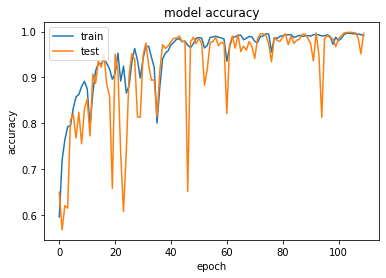

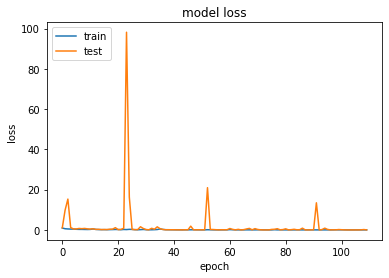

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 2657 	accurately-predicted-data: 2591 	 wrongly-predicted-data:  66
Accuracy: 97.516 %


In [ ]:
best_model = load_model('model.h5')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [ ]:
print('Accuracy for label different from 0')
print(np.mean(y_test2[y_test2 != 0] == y_pred[y_test2 != 0]))

In [ ]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

In [ ]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

In [ ]:
!pip install gradio

     |████████████████████████████████| 1.1MB 14.1MB/s 
     |████████████████████████████████| 215kB 35.7MB/s 
     |████████████████████████████████| 1.9MB 37.3MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 3.2MB 54.4MB/s 
     |████████████████████████████████| 962kB 56.9MB/s 
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=8b0486143536ed5b41f29fc211d6b0428487fdcf5341dd515ef344c90737d34e
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=232c0fa6e540f85cc345d9b5e3e4e318418b3877d0ecbe663097edcf27261d9d
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
Successfully built flask-cachebuster ffmpy


In [ ]:
import gradio as gr

In [ ]:
def predict_image(img):
  img_4d=img.reshape(-1,75,75,3)
  prediction=model.predict(img_4d)[0]
  return {lesion_names[i]: float(prediction[i]) for i in range(7)}

In [ ]:
image = gr.inputs.Image(shape=(100,100))
label = gr.outputs.Label(num_top_classes=7)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')